**Importing libraries and packages**

In [ ]:
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout, Dense, Flatten, MaxPooling2D, Conv2D, Reshape, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
import tensorflow_hub as hub

**Preprocessing**

In [ ]:
# !ls /content/drive/MyDrive/CV_4022/four-corners/

In [ ]:
# !ls /content/drive/MyDrive/CV_4022/four-corners/images

In [ ]:
# !ls /content/drive/MyDrive/CV_4022/four-corners/labels

In [ ]:
data_dir = '/content/drive/MyDrive/CV_4022/four-corners/'
# Walk through four-corners directory and list number of files
for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 2 directories and 1 files in '/content/drive/MyDrive/CV_4022/four-corners/'.
There are 0 directories and 1883 files in '/content/drive/MyDrive/CV_4022/four-corners/labels'.
There are 0 directories and 1883 files in '/content/drive/MyDrive/CV_4022/four-corners/images'.


**store model checkpoints during training**

In [ ]:
# Define the directory to save the checkpoints
checkpoint_dir = '/content/drive/MyDrive/CV_4022/checkpoints'
checkpoint_path = checkpoint_dir + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',  # Save after each epoch
    verbose=1
)

# add this to fit method
# callbacks=[checkpoint_callback]

# Load the weights from the checkpoint
# latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
# new_model.load_weights(latest_checkpoint)

**3.1.Design the model architecture**

In [ ]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
# First convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D((2, 2)))

# Fourth convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
model.add(MaxPooling2D((2, 2)))

# Flatten the output and add fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer with 8 neurons (4 corners with x and y coordinates)
model.add(Dense(8, activation='relu'))

In [ ]:
# model = Sequential()
# model.add(Input(shape=(224, 224, 3)))
# # First convolutional layer
# model.add(Conv2D(64, (3, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
# model.add(BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(MaxPooling2D((2, 2)))

# # Second convolutional layer
# model.add(Conv2D(64, (3, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(MaxPooling2D((2, 2)))

# # Third convolutional layer
# model.add(Conv2D(128, (3, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(MaxPooling2D((2, 2)))

# # Fourth convolutional layer
# model.add(Conv2D(128, (3, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(MaxPooling2D((2, 2)))

# # Fifth convolutional layer
# model.add(Conv2D(256, (3, 3), kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(MaxPooling2D((2, 2)))

# # Flatten the output and add fully connected layers
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))  # Dropout for regularization
# model.add(Dense(128, activation='relu'))

# # Output layer with 8 neurons (4 corners with x and y coordinates)
# model.add(Dense(8, activation='relu'))

In [ ]:
model.compile(loss = 'mse', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

**3.2. Enhance dataset with augmentation**

[0.37388323385737593, 0.35163498680068594, 0.6062665743722989, 0.366430929829726, 0.6030027634100107, 0.42387400276599907, 0.3745359960498336, 0.41081875891684605]


'87.jpg'

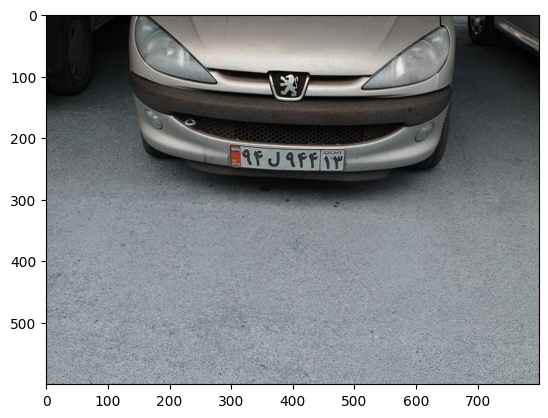

In [ ]:
# get one random image for testing

images_names = os.listdir(data_dir + 'images/')
random_img = random.randint(0, len(images_names))
random_img_name = images_names[random_img]

images_dir, labels_dir = data_dir + 'images/', data_dir + 'labels/'
img_path = os.path.join(images_dir, random_img_name)
label_path = os.path.join(labels_dir, random_img_name.replace('.jpg', '.txt'))

if os.path.exists(label_path):
    # Load image
    img = cv2.imread(img_path)

    # Load YOLO label
    with open(label_path, 'r') as f:
      label = f.readline().split(' ')
      x1, y1 = float(label[1]), float(label[2])
      x2, y2 = float(label[3]), float(label[4])
      x3, y3 = float(label[5]), float(label[6])
      x4, y4 = float(label[7]), float(label[8])
      label = [x1, y1, x2, y2, x3, y3, x4, y4]

plt.imshow(img)
print(label)
random_img_name

**Augmentation**

In [ ]:
def draw_plate(changed_image, changed_label):
  height = changed_image.shape[0]
  width = changed_image.shape[1]
  coordinates = [(int(changed_label[0]*width), int(changed_label[1]*height)),
                (int(changed_label[2]*width), int(changed_label[3]*height)),
                (int(changed_label[4]*width), int(changed_label[5]*height)),
                (int(changed_label[6]*width), int(changed_label[7]*height))]

  J = changed_image.copy()
  print(coordinates)
  cv2.line(J, coordinates[0], coordinates[1], (255, 0, 0), 3)
  cv2.line(J, coordinates[1], coordinates[2], (255, 0, 0), 3)
  cv2.line(J, coordinates[2], coordinates[3], (255, 0, 0), 3)
  cv2.line(J, coordinates[3], coordinates[0], (255, 0, 0), 3)

  return J

In [ ]:
def is_valid(image, points):
  h, w = image.shape[:2]
  corners = np.array([
    [points[0] * w, points[1] * h],
    [points[2] * w, points[3] * h],
    [points[4] * w, points[5] * h],
    [points[6] * w, points[7] * h]
  ])
  # First column and second column of coordinates which are x and y values should be in image boundaries
  if all(0 < x < w for x in corners[:, 0]) and all(0 < y < h for y in corners[:, 1]):
    return True
  return False

In [ ]:
def rotate_image(image, angle, points):
    h, w = image.shape[:2]
    center = (w / 2, h / 2)
    # Center of rotation, angle, scale
    # Euclidean
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # cos(theta)   sin(theta)  (1-cos(theta))x - sin(theta)y
    # -sin(theta)  cos(theta)  (1-cos(theta))y + sin(theta)x

    # Apply rotation
    # M: 2*3 transformation matrix
    # dsize	size of the output
    rotated = cv2.warpAffine(image, M, (w, h))

    # Rotate bounding box corners
    corners = np.array([
        [points[0] * w, points[1] * h],
        [points[2] * w, points[3] * h],
        [points[4] * w, points[5] * h],
        [points[6] * w, points[7] * h]
    ])
    corners = np.hstack((corners, np.ones((4, 1))))
    rotated_points = M.dot(corners.T).T
    rotated_points = (rotated_points / [w, h]).flatten().tolist()

    return rotated, rotated_points

In [ ]:
def apply_rotate(image, points):
  angle = np.random.uniform(-15, 15)
  print('rotating ' + str(angle) + ' degrees')
  rotated_image, rotated_points = rotate_image(image, angle, points)
  while not is_valid(rotated_image, rotated_points):
    angle = np.random.uniform(-15, 15)
    print('rotating ' + str(angle) + ' degrees')
    rotated_image, rotated_points = rotate_image(image, angle, points)
  return rotated_image, rotated_points

rotating -11.662011059363063 degrees
[0.39897931065952646, 0.32070702476614316, 0.6243224567724127, 0.39782887247928755, 0.6124174498183876, 0.45320649732102763, 0.39064613115471386, 0.3788449999460791]


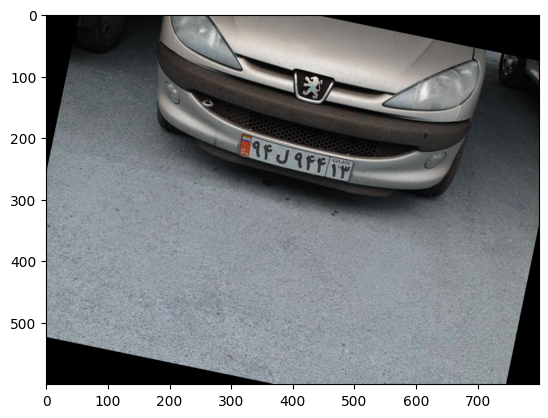

In [ ]:
# test it
rotated_img, rotated_label = apply_rotate(img, label)
plt.imshow(rotated_img)
print(rotated_label)

[(319, 192), (499, 238), (489, 271), (312, 227)]


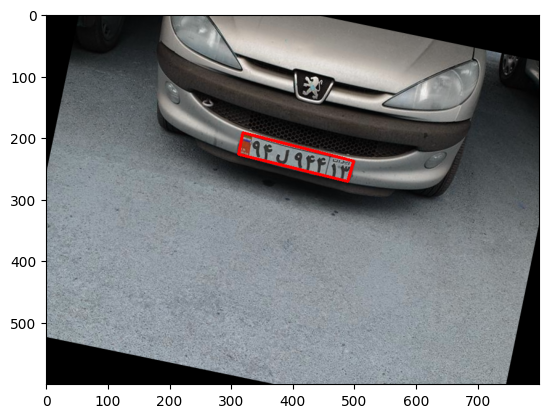

In [ ]:
img_with_plate = draw_plate(rotated_img, rotated_label)
plt.imshow(img_with_plate)

In [ ]:
def resize_image(image, resize_factor, points):
    # Because points are normalized, resizing doesn't affect them
    h, w = image.shape[:2]
    scaled = cv2.resize(image, (int(w * resize_factor), int(h * resize_factor)))
    return scaled, points

In [ ]:
def apply_resize(image, points):
  resize_factor = np.random.uniform(0.5, 2)
  print('resizing by factor: ' + str(resize_factor))
  resized_image, resized_points = resize_image(image, resize_factor, points)
  return resized_image, resized_points

resizing by factor: 0.5454572927589867
[0.37388323385737593, 0.35163498680068594, 0.6062665743722989, 0.366430929829726, 0.6030027634100107, 0.42387400276599907, 0.3745359960498336, 0.41081875891684605]


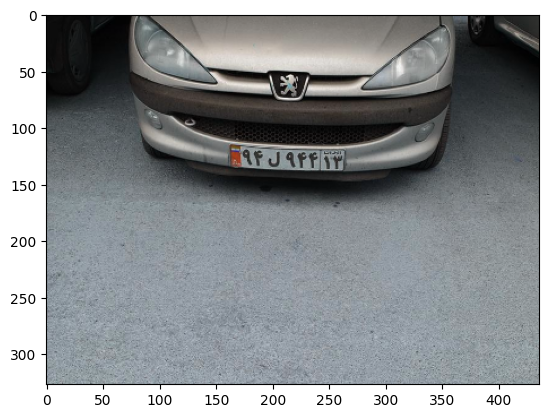

In [ ]:
# test it
resized_img, resized_label = apply_resize(img, label)
plt.imshow(resized_img)
print(resized_label)

[(163, 114), (264, 119), (262, 138), (163, 134)]


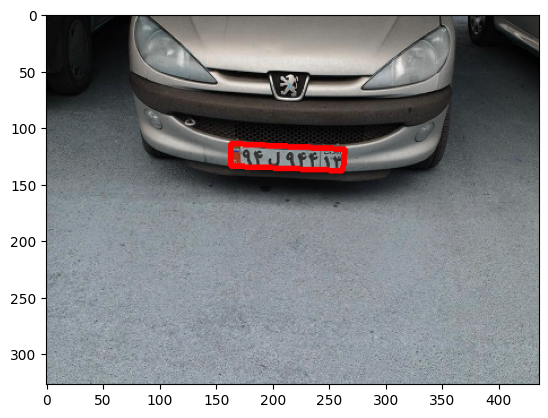

In [ ]:
img_with_plate = draw_plate(resized_img, resized_label)
plt.imshow(img_with_plate)

In [ ]:
def adjust_brightness(image, factor, points):
  # Changing brightness also doesn't affect points coordinates
  # Dst(I) = cast<uchar>(abs(src(I) * alpha + beta))
  return cv2.convertScaleAbs(image, alpha=factor, beta=0), points

In [ ]:
def apply_brightness(image, points):
  brightness_factor = np.random.uniform(0.1, 2)
  print('adjust brightness by factor: ' + str(brightness_factor))
  adjusted_image, adjusted_points = adjust_brightness(image, brightness_factor, points)
  return adjusted_image, adjusted_points

adjust brightness by factor: 0.18241796885103553
[0.37388323385737593, 0.35163498680068594, 0.6062665743722989, 0.366430929829726, 0.6030027634100107, 0.42387400276599907, 0.3745359960498336, 0.41081875891684605]


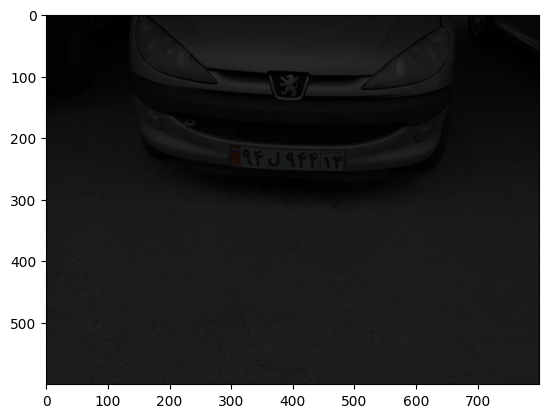

In [ ]:
# test it
adjusted_img, adjusted_label = apply_brightness(img, label)
plt.imshow(adjusted_img)
print(adjusted_label)

[(299, 210), (485, 219), (482, 254), (299, 246)]


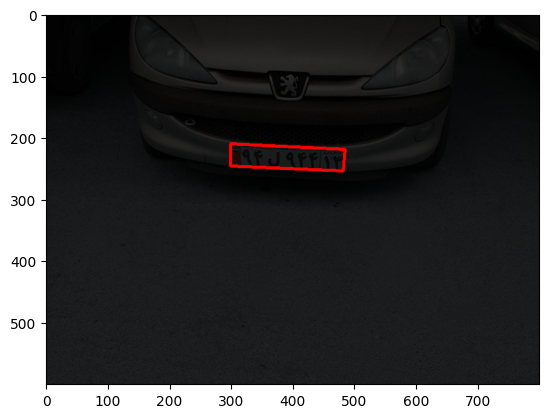

In [ ]:
img_with_plate = draw_plate(adjusted_img, adjusted_label)
plt.imshow(img_with_plate)

In [ ]:
def shift_image(image, x_shift, y_shift, points):
    h, w = image.shape[:2]
    M = np.array([[1, 0, x_shift],
                  [0, 1, y_shift]]).astype(np.float32)
    shifted = cv2.warpAffine(image, M, (w, h))

    points = np.array(points).reshape(4, 2)
    # First column(X's)
    points[:, 0] += x_shift / w
    # Second column(Y's)
    points[:, 1] += y_shift / h
    points = points.flatten().tolist()

    return shifted, points

In [ ]:
def apply_shift(image, points):
  h, w = image.shape[:2]
  x_shift = np.random.uniform(-(w/2), (w/2))
  y_shift = np.random.uniform(-(h/2), (h/2))
  print('x_shift: ' + str(x_shift), 'y_shift: ' + str(y_shift))
  shifted_image, shifted_points = shift_image(image, x_shift, y_shift, points)
  while not is_valid(shifted_image, shifted_points):
    x_shift = np.random.uniform(-(w/2), (w/2))
    y_shift = np.random.uniform(-(h/2), (h/2))
    print('x_shift: ' + str(x_shift), 'y_shift: ' + str(y_shift))
    shifted_image, shifted_points = shift_image(image, x_shift, y_shift, points)
  return shifted_image, shifted_points

x_shift: -339.7158112404967 y_shift: 154.83601833581565
x_shift: 16.982730751633028 y_shift: -231.7142535900548
x_shift: -173.28025754816255 y_shift: -16.16325012919185
[0.15728291192217275, 0.32469623658536617, 0.38966625243709574, 0.33949217961440625, 0.3864024414748075, 0.3969352525506793, 0.15793567411463044, 0.3838800087015263]


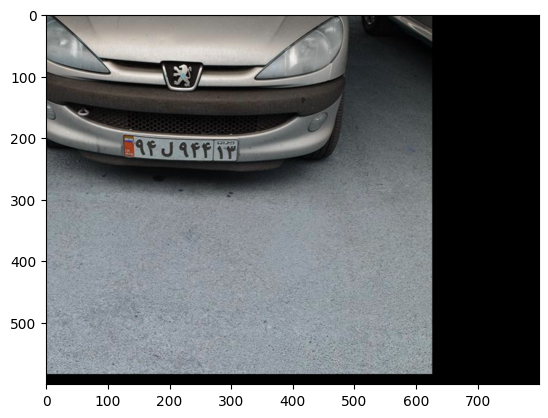

In [ ]:
# test it
shifted_img, shifted_label = apply_shift(img, label)
plt.imshow(shifted_img)
print(shifted_label)

[(125, 194), (311, 203), (309, 238), (126, 230)]


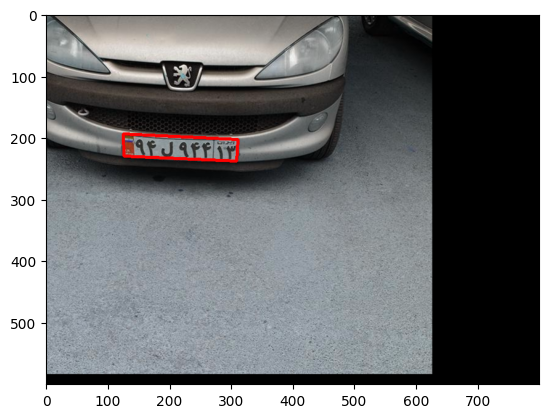

In [ ]:
img_with_plate = draw_plate(shifted_img, shifted_label)
plt.imshow(img_with_plate)

In [ ]:
def blur_image(image, ksize, points):
  # Blurring doesn't change point coordinates
  return cv2.GaussianBlur(image, (ksize, ksize), 0), points

In [ ]:
def apply_blur(image, points):
  ksize = np.random.choice(range(3, 25, 2))
  print('blur with k: ' + str(ksize))
  blurred_image, blurred_points = blur_image(image, ksize, points)
  return blurred_image, blurred_points

blur with k: 21
[0.37388323385737593, 0.35163498680068594, 0.6062665743722989, 0.366430929829726, 0.6030027634100107, 0.42387400276599907, 0.3745359960498336, 0.41081875891684605]


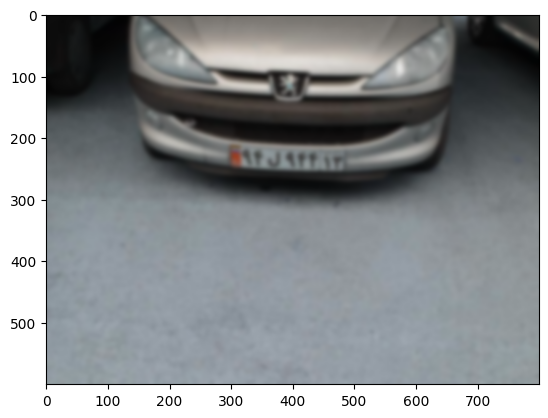

In [ ]:
# test it
blurred_img, blurred_label = apply_blur(img, label)
plt.imshow(blurred_img)
print(blurred_label)

[(299, 210), (485, 219), (482, 254), (299, 246)]


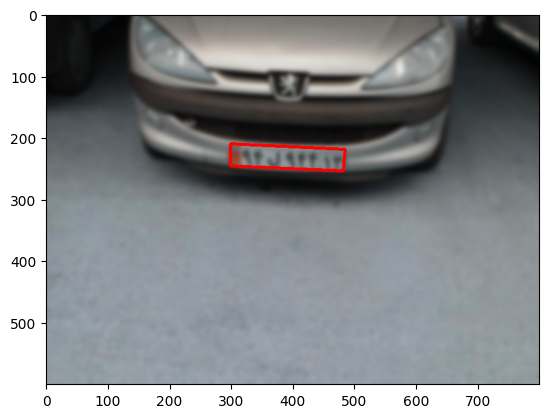

In [ ]:
img_with_plate = draw_plate(blurred_img, blurred_label)
plt.imshow(img_with_plate)

In [ ]:
def crop_image(image, crop_size, points):
    h, w = image.shape[:2]
    # cropped image size
    crop_h, crop_w = crop_size
    start_x = np.random.randint(0, w - crop_w + 1)
    start_y = np.random.randint(0, h - crop_h + 1)
    cropped = image[start_y:start_y + crop_h, start_x:start_x + crop_w]

    points = np.array(points).reshape(4, 2)
    # First column(X's)
    points[:, 0] = (points[:, 0] * w - start_x) / crop_w
    # Second column(Y's)
    points[:, 1] = (points[:, 1] * h - start_y) / crop_h
    points = points.flatten().tolist()

    return cropped, points

In [ ]:
def apply_crop(image, points):
  h, w = image.shape[:2]
  crop_size = (np.random.randint(50, h), np.random.randint(50, w))
  print('crop size: ' + str(crop_size))
  cropped_image, cropped_points = crop_image(image, crop_size, points)
  while not is_valid(cropped_image, cropped_points):
    crop_size = (np.random.randint(50, h), np.random.randint(50, w))
    print('crop size: ' + str(crop_size))
    cropped_image, cropped_points = crop_image(image, crop_size, points)
  return cropped_image, cropped_points

(600, 800, 3)
crop size: (76, 443)
crop size: (547, 455)
[0.13649799359538625, 0.31806397089654764, 0.5450840868084377, 0.33429352449330096, 0.5393455180835353, 0.39730237963363696, 0.13764570734036677, 0.38298218528356054]


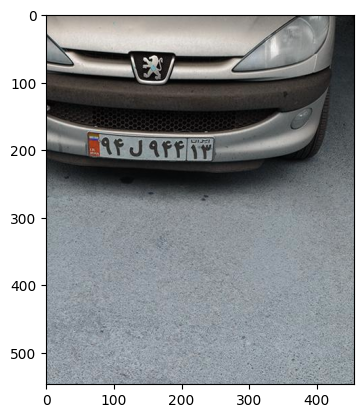

In [ ]:
# test it
print(img.shape)
cropped_img, cropped_label = apply_crop(img, label)
plt.imshow(cropped_img)
print(cropped_label)

[(62, 173), (248, 182), (245, 217), (62, 209)]


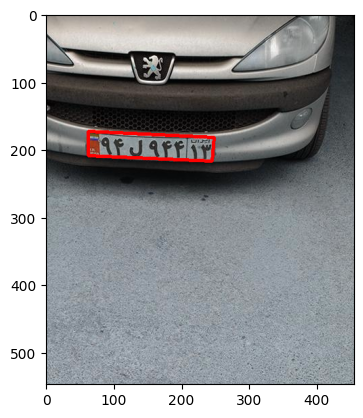

In [ ]:
img_with_plate = draw_plate(cropped_img, cropped_label)
plt.imshow(img_with_plate)

In [ ]:
# def perspective_transform(image, bbox):
#     h, w = image.shape[:2]
#     src_points = np.float32([
#         [0, 0],
#         [w - 1, 0],
#         [0, h - 1],
#         [w - 1, h - 1]
#     ])
#     dst_points = src_points + np.random.uniform(-50, 50, src_points.shape).astype(np.float32)
#     M = cv2.getPerspectiveTransform(src_points, dst_points)
#     perspective = cv2.warpPerspective(image, M, (w, h))

#     # Transform bounding box corners
#     corners = np.array([
#         [bbox[0] * w, bbox[1] * h],
#         [bbox[2] * w, bbox[3] * h],
#         [bbox[4] * w, bbox[5] * h],
#         [bbox[6] * w, bbox[7] * h]
#     ])
#     corners = np.hstack((corners, np.ones((4, 1))))
#     transformed_corners = M @ corners.T
#     transformed_corners = transformed_corners.T
#     perspective_bbox = (transformed_corners / [w, h, 1]).flatten().tolist()

#     return perspective, perspective_bbox

In [ ]:
def augment(image, points):
    aug_image = image.copy()
    aug_points = points.copy()

    if random.random() < 0.5:
      aug_image, aug_points = apply_rotate(aug_image, aug_points)

    if random.random() < 0.5:
      aug_image, aug_points = apply_resize(aug_image, aug_points)

    if random.random() < 0.5:
      aug_image, aug_points = apply_brightness(aug_image, aug_points)

    if random.random() < 0.5:
      aug_image, aug_points = apply_blur(aug_image, aug_points)

    # if random.random() < 0.5:
    #   aug_image, aug_points = apply_crop(aug_image, aug_points)

    if random.random() < 0.5:
      aug_image, aug_points = apply_shift(aug_image, aug_points)

    # aug_image, aug_points = perspective_transform(aug_image, aug_points)

    return aug_image, aug_points

**3.3. Normalize dataset samples**

In [ ]:
# Function to preprocess images
def resize(image, points):
    resized_image = cv2.resize(image, (224, 224))  # Resize image
    normalized_image = resized_image / 255.0  # Normalize pixel values
    return normalized_image, points

In [ ]:
# test
augmented_img, augmented_label = augment(img, label)

resizing by factor: 0.9850081939897224
x_shift: 8.547030449485305 y_shift: 128.66735923321454


In [ ]:
final_img, final_label = resize(img, label)

[0.3847297191993624, 0.5693462545387816, 0.6171130597142853, 0.5841421975678217, 0.6138492487519971, 0.6415852705040948, 0.3853824813918201, 0.6285300266549417]


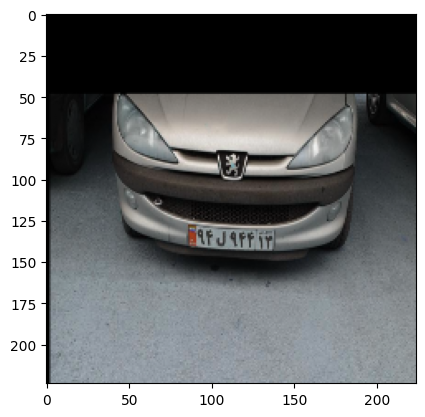

In [ ]:
augmented_img, augmented_label = resize(augmented_img, augmented_label)

plt.imshow(augmented_img)
print(augmented_label)

[(86, 127), (138, 130), (137, 143), (86, 140)]


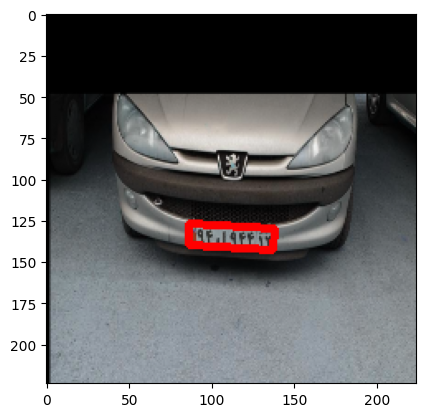

In [ ]:
augmented_img_with_plate = draw_plate(augmented_img, augmented_label)
plt.imshow(augmented_img_with_plate)

[0.37388323385737593, 0.35163498680068594, 0.6062665743722989, 0.366430929829726, 0.6030027634100107, 0.42387400276599907, 0.3745359960498336, 0.41081875891684605]


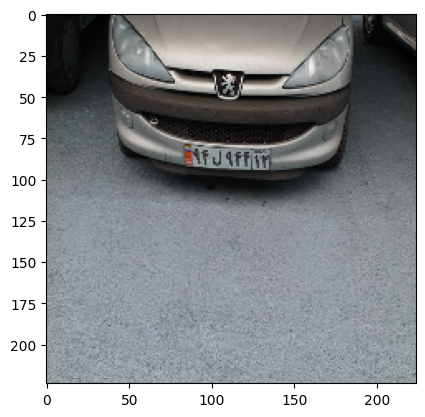

In [ ]:
plt.imshow(final_img)
print(final_label)

[(83, 78), (135, 82), (135, 94), (83, 92)]


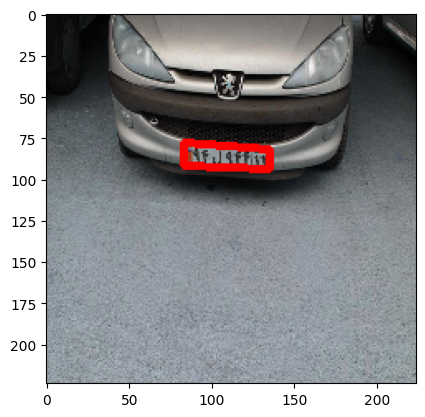

In [ ]:
img_with_plate = draw_plate(final_img, final_label)
plt.imshow(img_with_plate)

**A function to plot the loss and accuracy of the model that was trained**

In [ ]:
def show_final_result(history):
  # Plot separate loss curves for training and validation metrics.

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

**Loading**

First way to load data

In [ ]:
# def load(data_dir):
#     images = []
#     labels = []

#     images_dir, labels_dir = data_dir + 'images/', data_dir + 'labels/'

#     image_files = sorted(os.listdir(images_dir))

#     for img_file in image_files:
#         img_path = os.path.join(images_dir, img_file)
#         label_path = os.path.join(labels_dir, img_file.replace('.jpg', '.txt'))  # Adjust file extension as needed

#         if os.path.exists(label_path):
#             label = []
#             # Load YOLO labels
#             with open(label_path, 'r') as f:
#                 label = f.readline().split(' ')
#                 x1, y1 = float(label[1]), float(label[2])
#                 x2, y2 = float(label[3]), float(label[4])
#                 x3, y3 = float(label[5]), float(label[6])
#                 x4, y4 = float(label[7]), float(label[8])
#                 label = [x1, y1, x2, y2, x3, y3, x4, y4]  # YOLO format: classes,x1,y1,x2,y2,x3,y3,x4,y4

#             # Load image
#             image = cv2.imread(img_path)

#             augmented_image, augmented_label = apply_augment(img_file, image, label)

#             augmented_image, augmented_label = resize(augmented_image, augmented_label)
#             # Add augmented data to dataset
#             images.append(augmented_image)
#             labels.append(augmented_label)

#             image, label = resize(image, label)
#             images.append(image)
#             labels.append(label)

#     return np.array(images), np.array(labels)


In [ ]:
# images, labels = load(data_dir)
# images

Second way to load data which is faster

In [ ]:
aug_path = '/content/drive/MyDrive/CV_4022/four_corners_augmented/'

In [ ]:
def save_aug(aug_img_path, aug_label_path, aug_image, aug_label):
  # img_file = 'aug_' + img_file
  # Save augmented image
  cv2.imwrite(aug_img_path, aug_image)
  # Save augmented label
  # Open the file in write mode ('w')
  with open(aug_label_path, 'w') as file:
      # Write the text data to the file
      aug_label_str = '0 ' + ' '.join([str(x) for x in aug_label])
      file.write(aug_label_str)
  return

[(86, 127), (138, 130), (137, 143), (86, 140)]


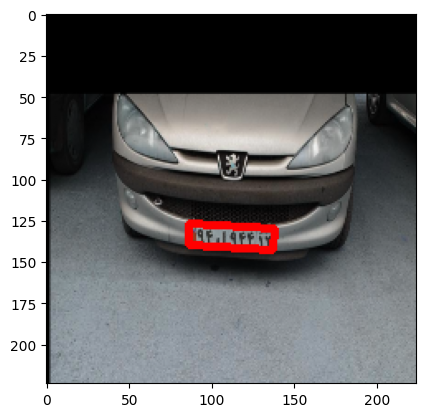

In [ ]:
# test it
test_aug_path = '/content/drive/MyDrive/CV_4022/test/'
aug_img_path = os.path.join(test_aug_path + 'images/', random_img_name)
aug_label_path = os.path.join(test_aug_path + 'labels/', random_img_name.replace('.jpg', '.txt'))
save_aug(aug_img_path, aug_label_path, augmented_img, augmented_label)
img_with_plate = draw_plate(augmented_img, augmented_label)
plt.imshow(img_with_plate)

In [ ]:
def apply_augment(img_file, image, label):
    aug_img_path = os.path.join(aug_path + 'images/', img_file)
    aug_label_path = os.path.join(aug_path + 'labels/', img_file.replace('.jpg', '.txt'))
    if os.path.exists(aug_label_path):
      # use the existing aug image
      augmented_image = cv2.imread(aug_img_path)
      with open(aug_label_path, 'r') as f:
          augmented_label = f.readline().split(' ')
          x1, y1 = float(augmented_label[1]), float(augmented_label[2])
          x2, y2 = float(augmented_label[3]), float(augmented_label[4])
          x3, y3 = float(augmented_label[5]), float(augmented_label[6])
          x4, y4 = float(augmented_label[7]), float(augmented_label[8])
          augmented_label = [x1, y1, x2, y2, x3, y3, x4, y4]  # YOLO format: classes,x1,y1,x2,y2,x3,y3,x4,y4
    else:
      # create a new one
      augmented_image, augmented_label = augment(image, label)
      # save it in a folder
      save_aug(aug_img_path, aug_label_path, augmented_image, augmented_label)

    return augmented_image, augmented_label

In [ ]:
class CustomDataGenerator(tf.keras.utils.Sequence):
  def __init__(self, image_files, image_dir, label_dir, batch_size=32, image_size=(224, 224), shuffle=True, augment=False):
    self.image_files = image_files
    self.image_dir = image_dir
    self.label_dir = label_dir
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.augment = augment
    self.indexes = np.arange(len(self.image_files))
    self.on_epoch_end()

  # Returns the number of batches per epoch.
  def __len__(self):
    return int(np.floor(len(self.image_files) / self.batch_size))

  def on_epoch_end(self):
    if self.shuffle:
        np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    # Gives the i's batch file indexes
    indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
    # File names
    batch_image_files = [self.image_files[k] for k in indexes]
    # Generate the data
    images, labels = self.__data_generation(batch_image_files)
    return np.array(images), np.array(labels)

  def __data_generation(self, batch_image_files):
    images = []
    labels = []

    for img_file in batch_image_files:
      img_path = os.path.join(self.image_dir, img_file)
      label_path = os.path.join(self.label_dir, img_file.replace('.jpg', '.txt'))

      if os.path.exists(label_path):
        # Load YOLO labels
        with open(label_path, 'r') as f:
          label = f.readline().split(' ')
          x1, y1 = float(label[1]), float(label[2])
          x2, y2 = float(label[3]), float(label[4])
          x3, y3 = float(label[5]), float(label[6])
          x4, y4 = float(label[7]), float(label[8])
          label = [x1, y1, x2, y2, x3, y3, x4, y4]  # YOLO format: classes,x1,y1,x2,y2,x3,y3,x4,y4

        # Load image
        image = cv2.imread(img_path)
        if self.augment:
          augmented_image, augmented_label = apply_augment(img_file, image, label)
          # Add augmented data to dataset
          augmented_image, augmented_label = resize(augmented_image, augmented_label)
          images.append(augmented_image)
          labels.append(augmented_label)

        image, label = resize(image, label)
        images.append(image)
        labels.append(label)

    return images, labels

**Split the data into train and test subsets**

First way

In [ ]:
# # Split dataset into train and test sets
# train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# print(f"Number of training samples: {len(train_images)}")
# print(f"Number of testing samples: {len(test_images)}")

second way

In [ ]:
# Define directories
image_dir = data_dir + 'images/'
label_dir = data_dir + 'labels/'

# Get list of all image files
all_image_files = [f for f in os.listdir(image_dir)]

# Shuffle and split into train and test sets
random.shuffle(all_image_files)
split_index = int(0.8 * len(all_image_files))  # 80% for training, 20% for testing
train_image_files = all_image_files[:split_index]
test_image_files = all_image_files[split_index:]

In [ ]:
# Create the data generators
train_generator = CustomDataGenerator(train_image_files, image_dir, label_dir, augment=True)
test_generator = CustomDataGenerator(test_image_files, image_dir, label_dir, augment=True)

**3.4. Train the model**

First way

In [ ]:
# history = model.fit(train_images, train_labels, batch_size=32, epochs=10, validation_data=(test_images, test_labels), callbacks=[checkpoint_callback])
# show_final_result(history)

second way

Epoch 1/8
47/47 [==============================] - ETA: 0s - loss: 0.9120 
Epoch 1: saving model to /content/drive/MyDrive/CV_4022/checkpoints/cp-0001.ckpt
47/47 [==============================] - 969s 21s/step - loss: 0.9120 - val_loss: 0.7327
Epoch 2/8
47/47 [==============================] - ETA: 0s - loss: 0.6302 
Epoch 2: saving model to /content/drive/MyDrive/CV_4022/checkpoints/cp-0002.ckpt
47/47 [==============================] - 957s 20s/step - loss: 0.6302 - val_loss: 0.5386
Epoch 3/8
47/47 [==============================] - ETA: 0s - loss: 0.4852 
Epoch 3: saving model to /content/drive/MyDrive/CV_4022/checkpoints/cp-0003.ckpt
47/47 [==============================] - 959s 20s/step - loss: 0.4852 - val_loss: 0.4359
Epoch 4/8
47/47 [==============================] - ETA: 0s - loss: 0.4081 
Epoch 4: saving model to /content/drive/MyDrive/CV_4022/checkpoints/cp-0004.ckpt
47/47 [==============================] - 956s 20s/step - loss: 0.4081 - val_loss: 0.3832
Epoch 5/8
47/47 [===

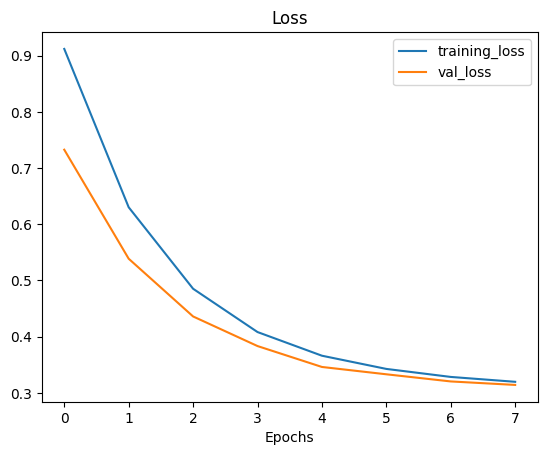

In [ ]:
# Train the model using the train data generator
history = model.fit(train_generator, epochs=8, steps_per_epoch=len(train_generator), validation_data=test_generator, validation_steps=len(test_generator), verbose=1, callbacks=[checkpoint_callback])
show_final_result(history)

**or**

In [ ]:
check_dir = '/content/drive/MyDrive/CV_4022/checkpoints_for_model_1'
# Load the weights from the checkpoint
latest_checkpoint = tf.train.latest_checkpoint(check_dir)
model.load_weights(latest_checkpoint)

**3.5. Test the model**

In [ ]:
def convert_scale(output_label, image):
  h, w = image.shape[:2]
  corners = np.array([
    float(output_label[0] * w), float(output_label[1] * h),
    float(output_label[2] * w), float(output_label[3] * h),
    float(output_label[4] * w), float(output_label[5] * h),
    float(output_label[6] * w), float(output_label[7] * h)
  ])
  return corners

In [ ]:
def corner(image):
  image_resized = cv2.resize(image, (224, 224))  # Resize image
  image_resized = image_resized / 255.0  # Normalize pixel values
  # inputting it into the network
  input_image_expanded = np.expand_dims(image_resized, axis=0)  # Expand dimensions to match (1, 224, 224, 3)
  output_label = model.predict(input_image_expanded)
  print(output_label)
  output_label = np.squeeze(output_label)  # Remove the batch dimension to get the final output

  return convert_scale(output_label, image)

1/1 [==============================] - 0s 57ms/step
[[0.4102884  0.2956042  0.62344354 0.31067497 0.6063616  0.34669173
  0.41880417 0.34429955]]
predicted four corners:  [328.2307148  177.3625195  498.75483513 186.40497923 485.08930206
 208.01503658 335.04333496 206.57973289]


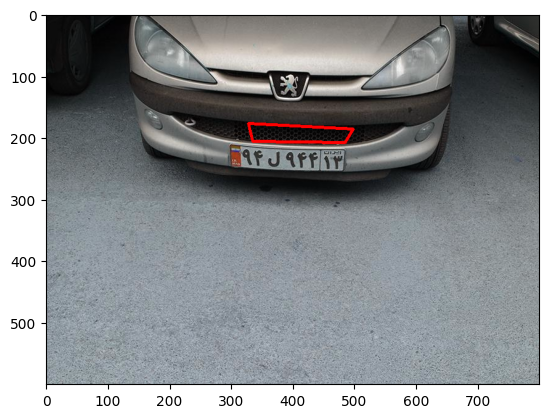

In [ ]:
# test it
predicted_label = corner(img)
print('predicted four corners: ', predicted_label)

# Display the result
J = img.copy()
four_points = np.array([[int(predicted_label[0]), int(predicted_label[1])],
                        [int(predicted_label[2]), int(predicted_label[3])],
                        [int(predicted_label[4]), int(predicted_label[5])],
                        [int(predicted_label[6]), int(predicted_label[7])]])
cv2.line(J, four_points[0], four_points[1], (255, 0, 0), 3)
cv2.line(J, four_points[1], four_points[2], (255, 0, 0), 3)
cv2.line(J, four_points[2], four_points[3], (255, 0, 0), 3)
cv2.line(J, four_points[3], four_points[0], (255, 0, 0), 3)
plt.imshow(J)

In [ ]:
y_true = []
y_pred = []

original_path = '/content/drive/MyDrive/CV_4022/four-corners/'
aug_path = '/content/drive/MyDrive/CV_4022/four_corners_augmented/'

for path in [original_path, aug_path]:
  for name in test_image_files:
    img_path = os.path.join(path + 'images/', name)
    label_path = os.path.join(path + 'labels/', name.replace('.jpg', '.txt'))
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = f.readline().split(' ')
        x1, y1 = float(label[1]), float(label[2])
        x2, y2 = float(label[3]), float(label[4])
        x3, y3 = float(label[5]), float(label[6])
        x4, y4 = float(label[7]), float(label[8])
        label = [x1, y1, x2, y2, x3, y3, x4, y4]
      # Load image
      image = cv2.imread(img_path)
      label_pred = corner(image)
      y_pred.append(label_pred)
      y_true.append(convert_scale(label, image))

1/1 [==============================] - 0s 60ms/step
[[0.5204532  0.6355889  0.6824047  0.66179764 0.6407247  0.7058844
  0.5294554  0.6768288 ]]
1/1 [==============================] - 0s 65ms/step
[[0.35005313 0.29896086 0.5437176  0.31355423 0.5305285  0.33495954
  0.36039728 0.34169984]]
1/1 [==============================] - 0s 55ms/step
[[0.42609668 0.62978584 0.68346137 0.6381124  0.6641473  0.6895635
  0.43418008 0.6999932 ]]
1/1 [==============================] - 0s 56ms/step
[[0.43807882 0.5569796  0.6424116  0.57396996 0.6039215  0.6233387
  0.44158444 0.6008403 ]]
1/1 [==============================] - 0s 58ms/step
[[0.3864482  0.41473442 0.6077002  0.42524663 0.5905683  0.4661752
  0.39394334 0.46860805]]
1/1 [==============================] - 0s 70ms/step
[[0.42630962 0.4997911  0.68481606 0.50389314 0.68382263 0.56352425
  0.4403796  0.56384116]]
1/1 [==============================] - 0s 57ms/step
[[0.36020657 0.36604863 0.5676001  0.38426378 0.5453533  0.41153473
  0.3683

In [ ]:
# Convert list to tensor
y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

# Compute MSE using TensorFlow operations
mse = tf.reduce_mean(tf.square(y_true - y_pred))
mse.numpy()

18383.74

In [ ]:
y_true

<tf.Tensor: shape=(754, 8), dtype=float32, numpy=
array([[714.4265 , 496.47958, 792.51373, ..., 519.92957, 712.5219 ,
        512.9065 ],
       [276.04187, 383.02554, 405.0476 , ..., 402.52158, 279.77515,
        418.69916],
       [242.39116, 353.50415, 360.36356, ..., 373.0659 , 243.59496,
        375.47348],
       ...,
       [100.34095, 314.4609 , 216.08568, ..., 318.92978, 106.90539,
        336.1253 ],
       [219.96884, 457.60104, 467.19476, ..., 514.2254 , 216.9354 ,
        503.10275],
       [561.98627, 747.3623 , 935.35187, ..., 856.2707 , 555.5294 ,
        818.6354 ]], dtype=float32)>

In [ ]:
y_pred

<tf.Tensor: shape=(754, 8), dtype=float32, numpy=
array([[ 666.1801 ,  521.18286,  873.478  , ...,  578.8252 ,  677.70294,
         554.99963],
       [ 251.33815,  382.66992,  390.38925, ...,  428.7482 ,  258.76526,
         437.3758 ],
       [ 255.658  ,  377.8715 ,  410.0768 , ...,  413.7381 ,  260.50806,
         419.9959 ],
       ...,
       [ 214.43794,  442.60574,  301.9041 , ...,  491.7548 ,  220.0638 ,
         477.59253],
       [ 290.15527,  468.76108,  463.7277 , ...,  528.72345,  292.0906 ,
         506.3413 ],
       [1021.50476,  599.31824, 1493.4231 , ...,  671.8008 , 1037.2053 ,
         665.48926]], dtype=float32)>

In [ ]:
!ls /content/drive/MyDrive/CV_4022/test/

images	labels


In [ ]:
y_true2 = []
y_pred2 = []

path = '/content/drive/MyDrive/CV_4022/test/'
images_path = os.path.join(path + 'images/')
labels_path = os.path.join(path + 'labels/')
file_names = os.listdir(images_path)

for name in file_names:
  image_path = os.path.join(images_path, name)
  label_path = os.path.join(labels_path, name.replace('.jpg', '.txt'))
  if os.path.exists(label_path):
    label = []
    with open(label_path, 'r') as f:
      label = f.readline().split(' ')
      x1, y1 = float(label[1]), float(label[2])
      x2, y2 = float(label[3]), float(label[4])
      x3, y3 = float(label[5]), float(label[6])
      x4, y4 = float(label[7]), float(label[8])
      label = [x1, y1, x2, y2, x3, y3, x4, y4]
    # Load image
    image = cv2.imread(image_path)
    label_pred = corner(image)
    y_pred2.append(label_pred)
    y_true2.append(convert_scale(label, image))

# Convert list to tensor
y_true2 = tf.convert_to_tensor(y_true2, dtype=tf.float32)
y_pred2 = tf.convert_to_tensor(y_pred2, dtype=tf.float32)

# Compute MSE using TensorFlow operations
mse = tf.reduce_mean(tf.square(y_true2 - y_pred2))
mse.numpy()

1/1 [==============================] - 0s 122ms/step
[[0.4180692  0.47355026 0.60264206 0.4873113  0.5924771  0.5194943
  0.43365592 0.5250099 ]]
1/1 [==============================] - 0s 71ms/step
[[0.38763267 0.5535181  0.5990828  0.56257385 0.5810553  0.6203663
  0.39914033 0.6028515 ]]
1/1 [==============================] - 0s 74ms/step
[[0.36006433 0.41413316 0.58195394 0.41911155 0.57223743 0.46694526
  0.37170038 0.46874124]]
1/1 [==============================] - 0s 75ms/step
[[0.37684014 0.33307752 0.59780085 0.34699467 0.58247    0.38289323
  0.38320875 0.3843147 ]]
1/1 [==============================] - 0s 59ms/step
[[0.44780567 0.48327655 0.63306826 0.5011765  0.61893654 0.53136814
  0.46213356 0.535609  ]]
1/1 [==============================] - 0s 60ms/step
[[0.2316894  0.65185356 0.49215394 0.64538765 0.46626258 0.7408192
  0.24273807 0.6959051 ]]
1/1 [==============================] - 0s 100ms/step
[[0.5634517  0.48872763 0.8063952  0.50800216 0.77714384 0.55439323
  0.5

17936.248

first way

In [ ]:
# # Evaluate the model on the test data
# print("Evaluate on test data")
# loss = model.evaluate(test_images, test_labels, batch_size=128)
# print("Test loss:", loss)

second way

In [ ]:
loss = model.evaluate(test_generator)
print(f'Test Loss: {loss}')

11/11 [==============================] - 61s 5s/step - loss: 0.1642
Test Loss: 0.16423751413822174


**4.1. Generate your dataset!**

In [ ]:
%cd /content/drive/MyDrive/CV_4022

/content/drive/MyDrive/CV_4022


In [ ]:
! git clone https://github.com/kntu-utils/license-plate-generator.git

Cloning into 'license-plate-generator'...
remote: Enumerating objects: 721, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 721 (delta 6), reused 11 (delta 4), pack-reused 691
Receiving objects: 100% (721/721), 104.59 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Updating files: 100% (202/202), done.


In [ ]:
! pip install jsonnet-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jsonnet-binary: filename=jsonnet_binary-0.17.0-cp310-cp310-linux_x86_64.whl size=5628138 sha256=dc7c76dc7e4f4240cb1265299dc739ecfa2350267e174afecfe7a087278b6b15
  Stored in directory: /root/.cache/pip/wheels/38/e3/a4/2e00888916cd70d1148611b3ea207de668e0af185f74fc68d1
Successfully built jsonnet-binary


In [ ]:
! pip3 install --upgrade -r "/content/drive/MyDrive/CV_4022/license-plate-generator/requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astropy 5.3.4 requires numpy<2,>=1.21, but you have numpy 2.0.0 which is incompatible.
cu

In [ ]:
%cd "/content/drive/MyDrive/CV_4022/license-plate-generator/"

/content/drive/MyDrive/CV_4022/license-plate-generator


In [ ]:
! python3 main.py --count 4000 --no-fill --no-transform

python3: can't open file '/content/main.py': [Errno 2] No such file or directory


augmentation

In [ ]:
data_dir2 = "/content/drive/MyDrive/CV_4022/license-plate-generator/output/00"
image_dir2 = "/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/imgs"
label_dir2 = "/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/anns/xmls"
classes_dir = "/content/drive/MyDrive/CV_4022/license-plate-generator"

In [ ]:
for dirpath, dirnames, filenames in os.walk(data_dir2):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

There are 4 directories and 0 files in '/content/drive/MyDrive/CV_4022/license-plate-generator/output/00'.
There are 1 directories and 1149 files in '/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/anns'.
There are 0 directories and 4000 files in '/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/anns/xmls'.
There are 0 directories and 4000 files in '/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/imgs'.
There are 0 directories and 0 files in '/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/.ipynb_checkpoints'.
There are 0 directories and 4000 files in '/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/aug_imgs'.


In [ ]:
classes = []
with open(classes_dir + '/classes.txt', 'r') as file:
  lines = file.readlines()
  for line in lines:
    classes.append(line.split()[0])

classes = dict(enumerate(classes))
classes

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'P',
 13: 'T',
 14: 'S',
 15: 'J',
 16: 'CH',
 17: 'HE',
 18: 'KH',
 19: 'D',
 20: 'Z',
 21: 'R',
 22: 'ZE',
 23: 'ZH',
 24: 'SIN',
 25: 'SHIN',
 26: 'SAD',
 27: 'ZAD',
 28: 'TA',
 29: 'ZA',
 30: 'AIN',
 31: 'GHAIN',
 32: 'F',
 33: 'Q',
 34: 'K',
 35: 'G',
 36: 'L',
 37: 'M',
 38: 'N',
 39: 'V',
 40: 'H',
 41: 'Y',
 42: 'IRAN',
 43: 'Plate'}

In [ ]:
def encode_label(labels):
  label_coded = []
  for label in labels:
    coded = [1 if i==label else 0 for i in range(42)]
    label_coded.append(coded)
  return label_coded

In [ ]:
def decode_label(labels):
  decoded = []
  for label in labels:
    decoded.append(label.index(1))
  return decoded

In [ ]:
def get_plate_num(label):
  plate_num = ''
  for num in label:
    plate_num = plate_num + classes[num]
  return plate_num

01323.jpg
/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/anns/xmls/01323.txt
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 

'01323.jpg'

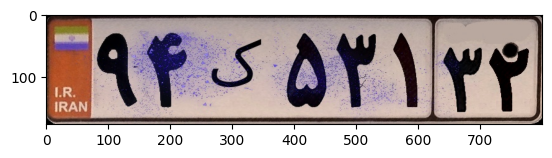

In [ ]:
# get one random image for testing

images_names2 = os.listdir(image_dir2)
random_img2 = random.randint(0, len(images_names2))
random_img_name2 = images_names2[random_img2]
print(random_img_name2)

img_path2 = os.path.join(image_dir2, random_img_name2)
label_path2 = os.path.join(label_dir2, random_img_name2.replace('.jpg', '.txt'))
print(label_path2)

if os.path.exists(label_path2):
    # Load image
    img2 = cv2.imread(img_path2)

    label2 = []
    with open(label_path2, 'r') as file:
      lines = file.readlines()
      for line in lines:
        # xcenter ycenter width height
        c, xc, yc, w, h = line.split(' ')
        # we don't need Iran class
        if c != '43':
          label2.append([int(c), float(xc), float(yc), float(w), float(h)])

# Sort by the Second column (x center)
label2.sort(key=lambda x: x[1])
label2 = [label[0] for label in label2]
label2 = encode_label(label2)

plt.imshow(img2)
for l in label2:
  print(l)

label2_dec = decode_label(label2)
print(label2_dec)
print(get_plate_num(label2_dec))

print(img2.shape)
random_img_name2

In [ ]:
def shift(image):
  h, w = image.shape[:2]
  x_shift = np.random.uniform(-5, 5)
  y_shift = np.random.uniform(-5, 5)

  M = np.array([[1, 0, x_shift],
                [0, 1, y_shift]]).astype(np.float32)
  shifted = cv2.warpAffine(image, M, (w, h))

  return shifted

(176, 800, 3)


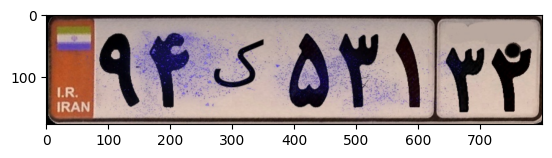

In [ ]:
# test it
shifted_img2 = shift(img2)
plt.imshow(shifted_img2)
print(img2.shape)

In [ ]:
def crop(image):
    h, w = image.shape[:2]
    # cropped image size
    crop_h, crop_w = np.random.randint(h-5, h), np.random.randint(w-5, w)
    start_x = np.random.randint(0, w - crop_w + 1)
    start_y = np.random.randint(0, h - crop_h + 1)
    cropped = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
    cropped = cv2.resize(cropped, (w, h))

    return cropped

(176, 800, 3)
(176, 800, 3)


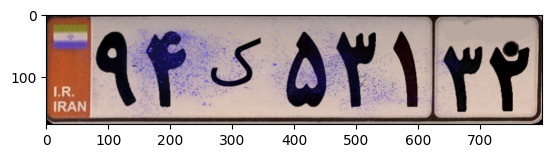

In [ ]:
# test it
cropped_img2 = crop(img2)
plt.imshow(cropped_img2)
print(img2.shape)
print(cropped_img2.shape)

In [ ]:
def blur(image):
  ksize = np.random.choice(range(3, 35, 2))
  return cv2.GaussianBlur(image, (ksize, ksize), 0)

(176, 800, 3)


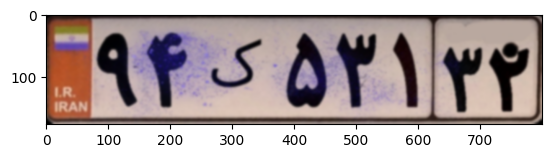

In [ ]:
# test it
blurred_img2 = blur(img2)
plt.imshow(blurred_img2)
print(img2.shape)

In [ ]:
def brightness(image):
  factor = np.random.uniform(0.5, 2)
  # Dst(I) = cast<uchar>(abs(src(I) * alpha + beta))
  return cv2.convertScaleAbs(image, alpha=factor, beta=0)

(176, 800, 3)


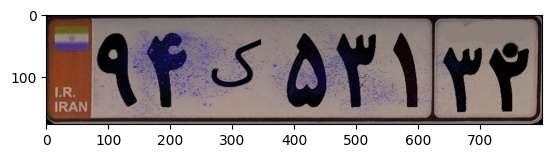

In [ ]:
# test it
adjusted_img2 = brightness(img2)
plt.imshow(adjusted_img2)
print(img2.shape)

In [ ]:
def rotate(image):
    h, w = image.shape[:2]
    center = (w / 2, h / 2)
    angle = np.random.uniform(-3, 3)
    # Center of rotation, angle, scale
    # Euclidean
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Apply rotation
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

(176, 800, 3)


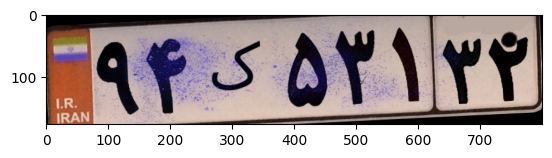

In [ ]:
# test it
rotated_img2 = rotate(img2)
plt.imshow(rotated_img2)
print(img2.shape)

In [ ]:
def dec_quality(image):
  # Set the desired quality level (0 to 100; higher means better quality)
  # Adjust this value to decrease quality
  quality = np.random.randint(10, 20)

  # Encode the image with the specified quality
  # it can be a quality from 0 to 100 (the higher is the better)
  encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
  result, encimg = cv2.imencode('.jpg', image, encode_param)

  # Decode the image back
  decimg = cv2.imdecode(encimg, 1)

  return decimg

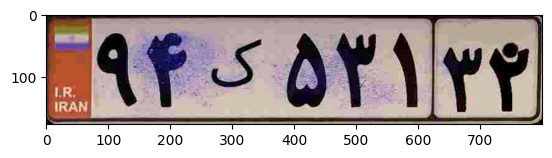

In [ ]:
dec_img2 = dec_quality(img2)
plt.imshow(dec_img2)

In [ ]:
def add_noise(img):
    img = img.astype(np.float32) / 255
    # create the noise image
    sigma = np.random.uniform(0, 0.4)
    gauss = np.random.randn(*img.shape) * sigma
    noisy = img + gauss
    return noisy

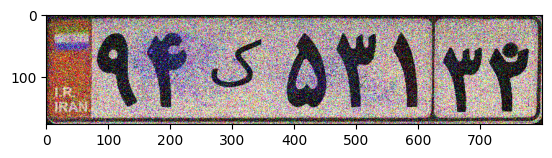

In [ ]:
# Add noise
noisy_image = add_noise(img2)
plt.imshow(noisy_image)

In [ ]:
def augment_plate(image):
    aug_image = image.copy()
    if random.random() < 0.8:
      aug_image = shift(aug_image)
    if random.random() < 0.8:
      aug_image = crop(aug_image)
    if random.random() < 0.8:
      aug_image = blur(aug_image)
    if random.random() < 0.8:
      aug_image = brightness(aug_image)
    if random.random() < 0.8:
      aug_image = rotate(aug_image)
    if random.random() < 0.4:
      aug_image = dec_quality(aug_image)
    if random.random() < 0.4:
      aug_image = add_noise(aug_image)

    return aug_image

(176, 800, 3)
(176, 800, 3)


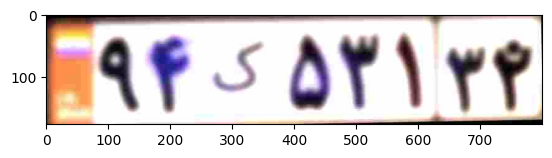

In [ ]:
# test
augmented_img2 = augment_plate(img2)
plt.imshow(augmented_img2)
print(img2.shape)
print(augmented_img2.shape)

In [ ]:
aug_dir2 = '/content/drive/MyDrive/CV_4022/license-plate-generator/output/00/aug_imgs'

In [ ]:
def save_aug2(aug_img_path, aug_image):
  # Save augmented image
  cv2.imwrite(aug_img_path, aug_image)
  return

In [ ]:
# test it
aug_img_path2 = os.path.join(aug_dir2, random_img_name2)
save_aug2(aug_img_path2, augmented_img2)

In [ ]:
def apply_augment2(img_file, image):
    aug_img_path = os.path.join(aug_dir2, img_file)
    if os.path.exists(aug_img_path):
      # use the existing aug image
      augmented_image = cv2.imread(aug_img_path)
    else:
      # create a new one
      augmented_image = augment_plate(image)
      # save it in a folder
      save_aug2(aug_img_path, augmented_image)

    return augmented_image

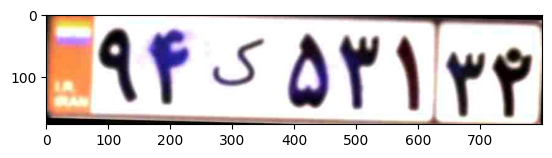

In [ ]:
# test
augmented_image = apply_augment2(random_img_name2, img2)
plt.imshow(augmented_image)

Data Generator

In [ ]:
class CustomPlateGenerator(tf.keras.utils.Sequence):
  def __init__(self, image_files, image_dir, label_dir, batch_size=32, shuffle=True, augment=False):
    self.image_files = image_files
    self.image_dir = image_dir
    self.label_dir = label_dir
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.augment = augment
    self.indexes = np.arange(len(self.image_files))
    self.on_epoch_end()

  # Returns the number of batches per epoch.
  def __len__(self):
    return int(np.floor(len(self.image_files) / self.batch_size))

  def on_epoch_end(self):
    if self.shuffle:
        np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    # Gives the i's batch file indexes
    indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
    # File names
    batch_image_files = [self.image_files[k] for k in indexes]
    # Generate the data
    images, labels = self.__data_generation(batch_image_files)
    # print(np.array(labels).shape)
    return np.array(images), np.array(labels)

  def __data_generation(self, batch_image_files):
    images = []
    labels = []

    for img_file in batch_image_files:
      img_path = os.path.join(self.image_dir, img_file)
      label_path = os.path.join(self.label_dir, img_file.replace('.jpg', '.txt'))

      if os.path.exists(label_path):
        # Find the label
        label = []
        with open(label_path, 'r') as file:
          lines = file.readlines()
          for line in lines:
            # xcenter ycenter width height
            c, xc, yc, w, h = line.split(' ')
            # we don't need Iran class
            if c != '43':
              label.append([int(c), float(xc), float(yc), float(w), float(h)])
        # Sort by the Second column (x center)
        label.sort(key=lambda x: x[1])
        label = [label[0] for label in label]
        # label = encode_label(label)

        # Load image
        image = cv2.imread(img_path)

        if self.augment:
          augmented_image = apply_augment2(img_file, image)
          # Add augmented data to dataset
          augmented_image = augmented_image / 255.0
          images.append(augmented_image)
          labels.append(label)

        image = image / 255.0
        images.append(image)
        labels.append(label)

    return images, labels

train test split

In [ ]:
# Get list of all image files
all_image_files2 = [f for f in os.listdir(image_dir2)]

# Shuffle and split into train and test sets
random.shuffle(all_image_files2)
split_index2 = int(0.8 * len(all_image_files2))  # 80% for training, 20% for testing
train_image_files2 = all_image_files2[:split_index2]
test_image_files2 = all_image_files2[split_index2:]

In [ ]:
# Create the data generators
train_generator2 = CustomPlateGenerator(train_image_files2, image_dir2, label_dir2, augment=True)
test_generator2 = CustomPlateGenerator(test_image_files2, image_dir2, label_dir2, augment=True)

**4.2. Design the model architecture**

In [ ]:
num_classes = 42
input_shape = (176, 800, 3)
num_characters = 8

In [ ]:
# Define the input layer
inputs = Input(shape=input_shape)

# Add convolutional layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the output
x = Flatten()(x)

# Reshape to split feature maps into num_characters segments
x = Reshape((num_characters, -1))(x)

# List to hold outputs
outputs = []

for i in range(num_characters):
    # Select feature vector for the i-th character
    feature_vector = Lambda(lambda x: x[:, i])(x)

    # Add dense layers to predict the class of each character
    fc = Dense(256, activation='relu')(feature_vector)
    fc = Dense(128, activation='relu')(fc)
    output = Dense(num_classes, activation='softmax')(fc)
    outputs.append(output)

# Stack all outputs
outputs = tf.stack(outputs, axis=1)

# Create the model
model2 = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile the model with an appropriate loss function
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# sparse_categorical_crossentropy: used when the labels are in integer format
# more memory efficient than CategoricalCrossentropy(one hot format)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 176, 800, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 174, 798, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 87, 399, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 85, 397, 64)          18496     ['max_pooling2d[0][0]']   

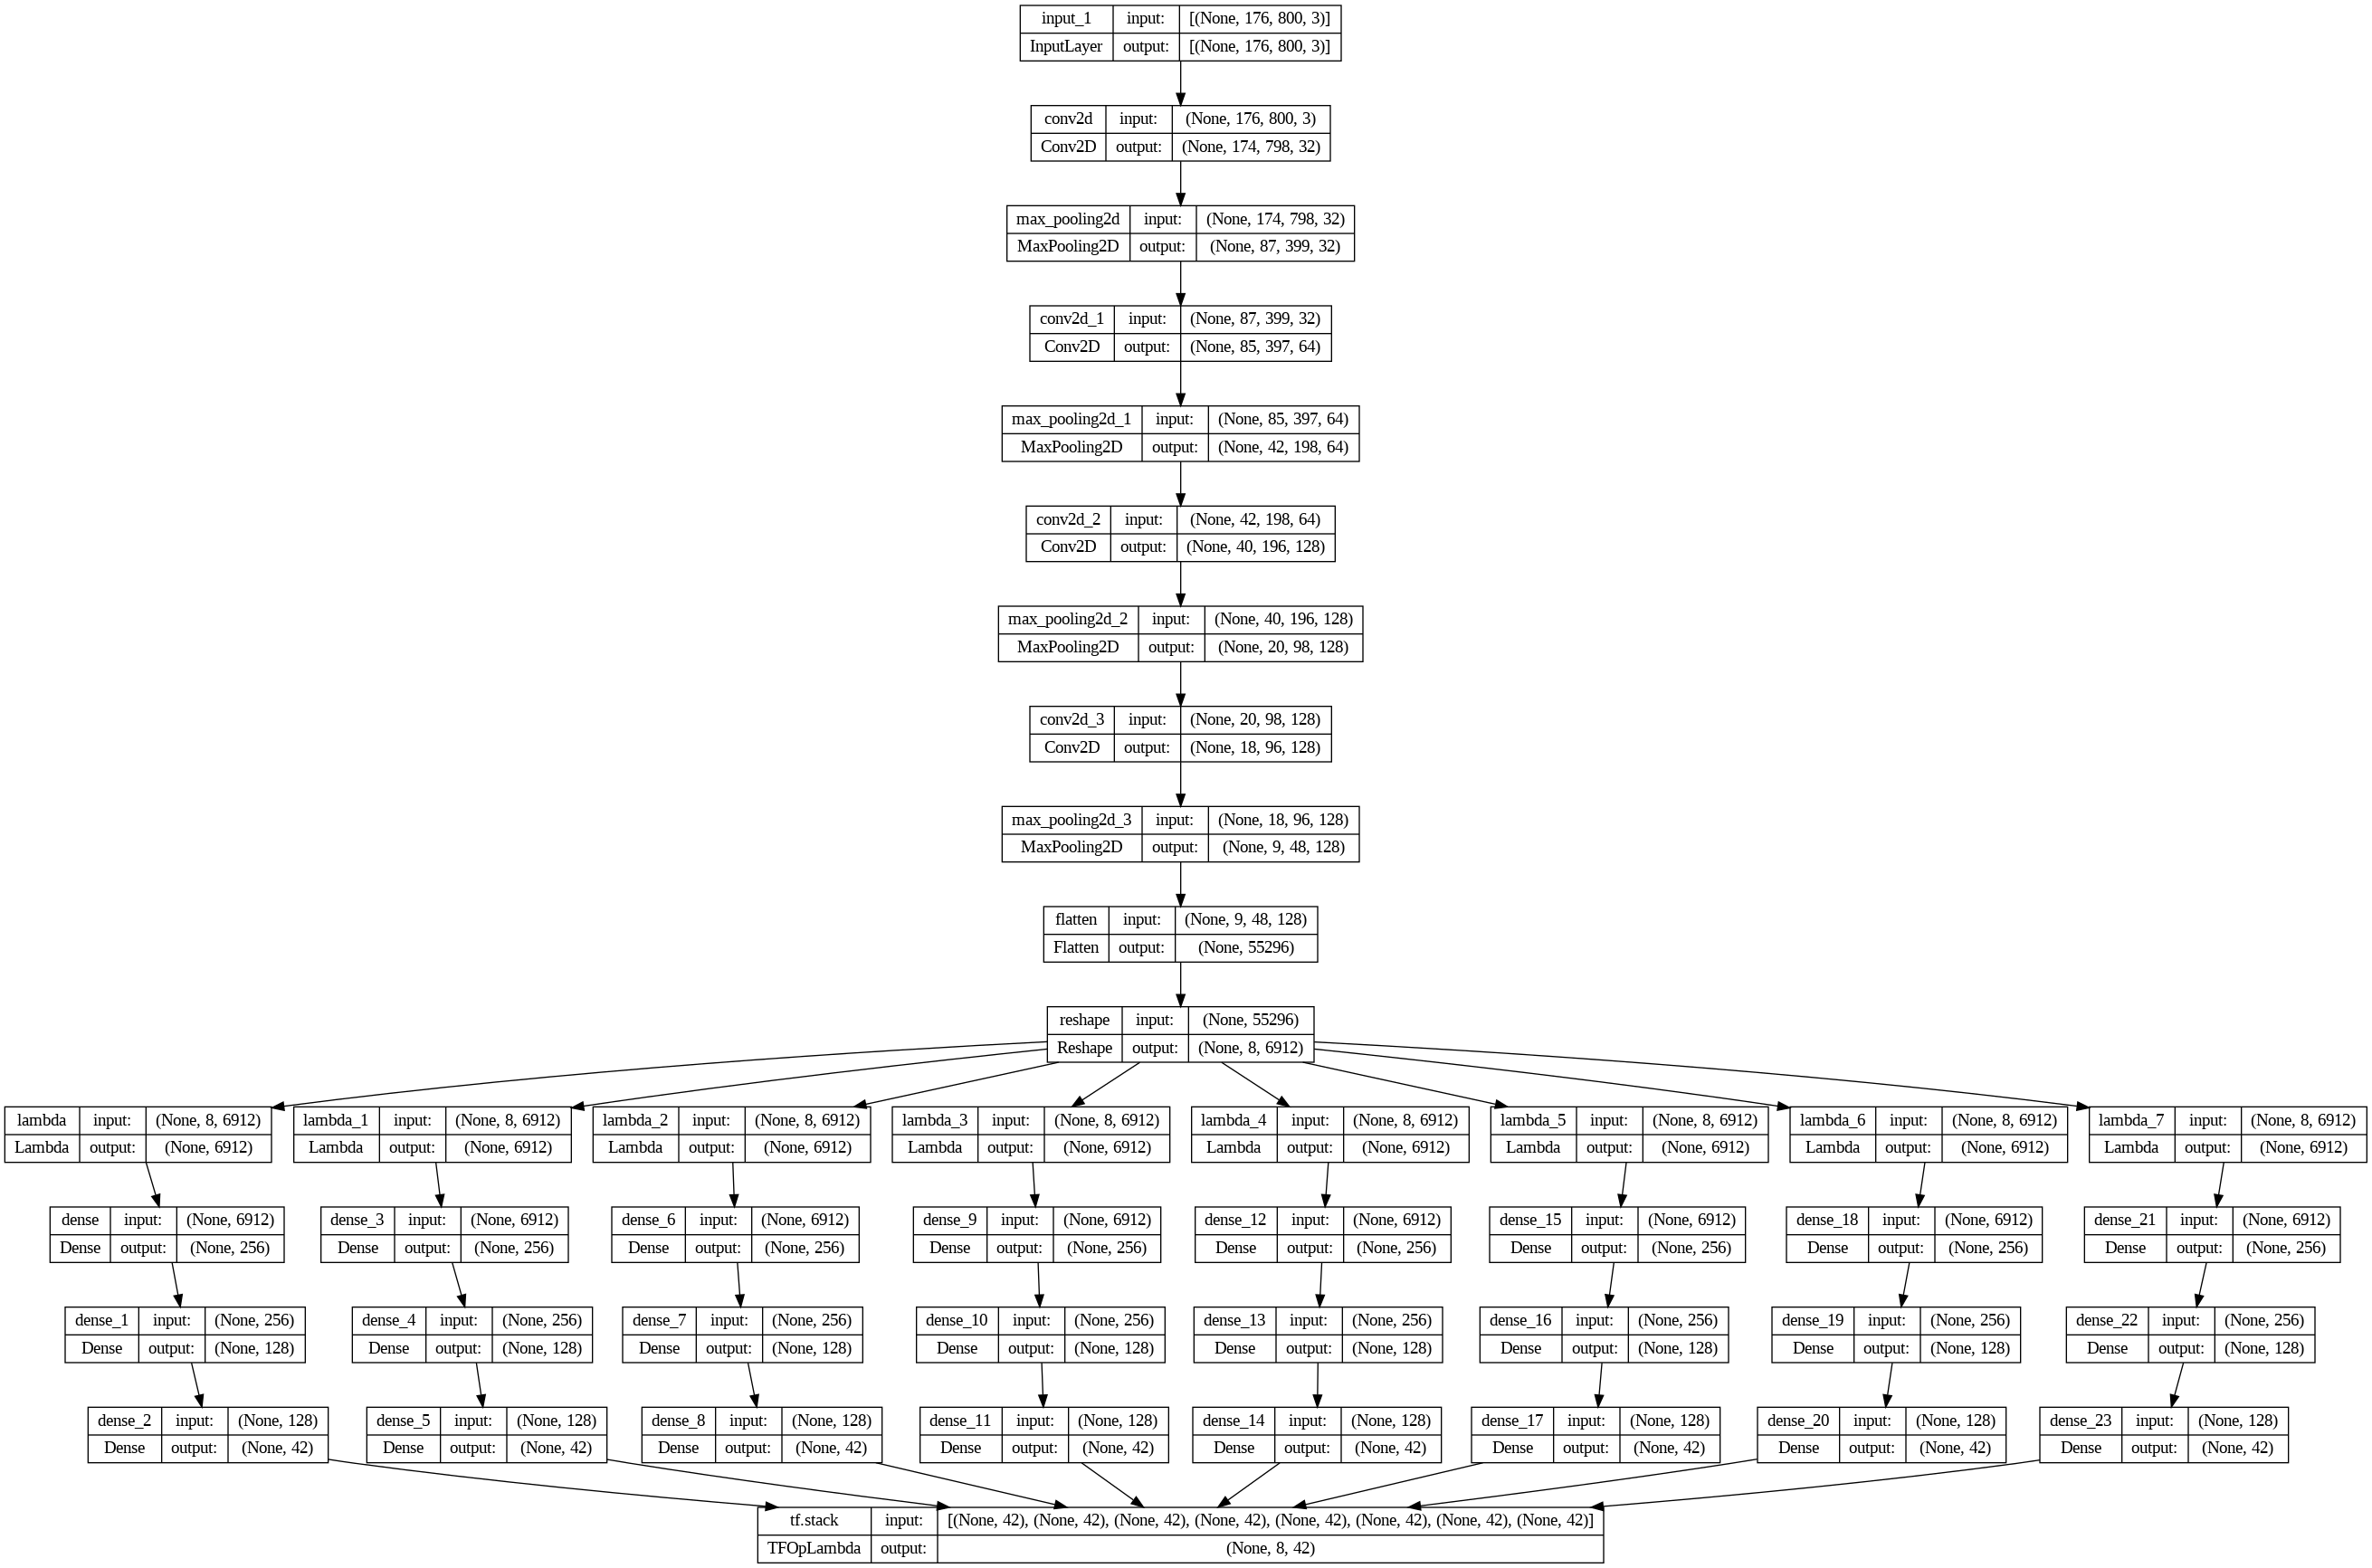

In [ ]:
tf.keras.utils.plot_model(model2, "my_first_model_with_shape_info.png", show_shapes=True)

**4.3. Train and test the model**

train

In [ ]:
def show_final_result2(history):
  # Plot separate loss curves for training and validation metrics.

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

**store model checkpoints during training**

In [ ]:
# Define the directory to save the checkpoints
checkpoint_dir2 = '/content/drive/MyDrive/CV_4022/checkpoints2'
checkpoint_path2 = checkpoint_dir2 + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights
checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_path2,
    save_weights_only=True,
    save_freq='epoch',  # Save after each epoch
    verbose=1
)

# add this to fit method
# callbacks=[checkpoint_callback2]

# Load the weights from the checkpoint
# latest_checkpoint2 = tf.train.latest_checkpoint(checkpoint_dir2)
# model.load_weights(latest_checkpoint2)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.7042 
Epoch 1: saving model to /content/drive/MyDrive/CV_4022/checkpoints2/cp-0001.ckpt
100/100 [==============================] - 2430s 24s/step - loss: 0.8147 - accuracy: 0.7042 - val_loss: 0.5860 - val_accuracy: 0.7776
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.4988 - accuracy: 0.8092 
Epoch 2: saving model to /content/drive/MyDrive/CV_4022/checkpoints2/cp-0002.ckpt
100/100 [==============================] - 2380s 24s/step - loss: 0.4988 - accuracy: 0.8092 - val_loss: 0.4951 - val_accuracy: 0.8059
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8445 
Epoch 3: saving model to /content/drive/MyDrive/CV_4022/checkpoints2/cp-0003.ckpt
100/100 [==============================] - 2422s 24s/step - loss: 0.3978 - accuracy: 0.8445 - val_loss: 0.4562 - val_accuracy: 0.8216
Epoch 4/10
100/100 [==============================] - ETA: 0s

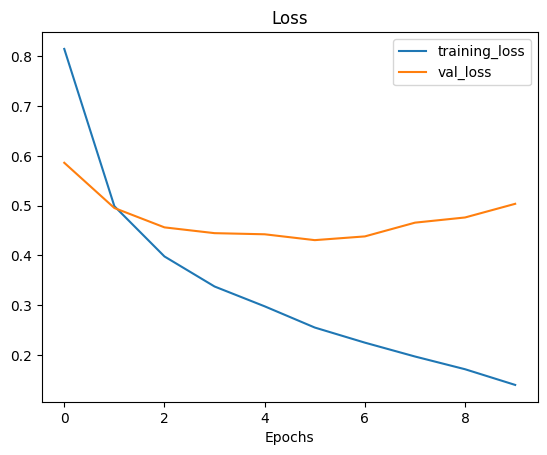

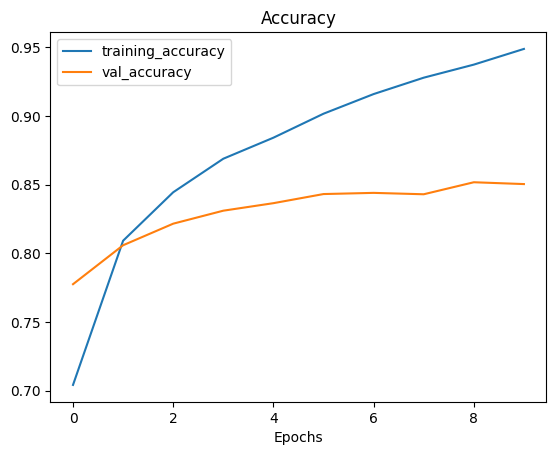

In [ ]:
# Train the model using the train data generator
history2 = model2.fit(train_generator2, epochs=10, validation_data=test_generator2, verbose=1, callbacks=[checkpoint_callback2])
show_final_result2(history2)

In [ ]:
check_dir2 = '/content/drive/MyDrive/CV_4022/checkpoints_for_model_2'
# Load the weights from the checkpoint
latest_checkpoint2 = tf.train.latest_checkpoint(check_dir2)
model2.load_weights(latest_checkpoint2)

test

In [ ]:
def read_plate(image: np.ndarray) -> str:
  image_scaled = image / 255.0  # Normalize pixel values
  # inputting it into the network
  input_image_expanded = np.expand_dims(image_scaled, axis=0)  # Expand dimensions to match (1, 176, 800, 3)
  output_label = model2.predict(input_image_expanded)
  output_label = np.squeeze(output_label)  # Remove the batch dimension to get the final output
  plate_num = ''
  for label in output_label:
    predicted_class = np.argmax(label)
    plate_num = plate_num + classes[predicted_class]

  return plate_num

1/1 [==============================] - 0s 116ms/step
predicted :  94A53132


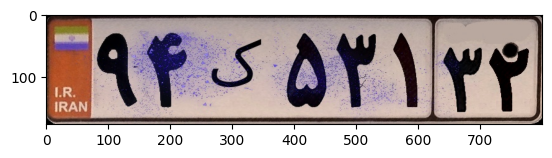

In [ ]:
# test it
predicted_label = read_plate(img2)
print('predicted : ', predicted_label)
plt.imshow(img2)

In [ ]:
# Evaluate the model
loss, accuracy = model2.evaluate(test_generator2)
print(f"Test accuracy: {accuracy}")

25/25 [==============================] - 588s 24s/step - loss: 0.3578 - accuracy: 0.8919
Test accuracy: 0.8918750286102295


**4.4. Integrate with the previous parts**

In [ ]:
# integrate.py

In [ ]:
def extract(image: np.ndarray, points: np.ndarray) -> np.ndarray:
    # select the highest distance in y direction as height
    # x0,y0 x0+w,y0, x0+w,y0+h, x0,y0+h
    h = max(np.abs(points[5] - points[1]),
            np.abs(points[7] - points[1]),
            np.abs(points[5] - points[3]),
            np.abs(points[7] - points[3]))
    # aspect ratio = 4.5
    w = 4.5 * h

    points = np.array([(points[0], points[1]), (points[2], points[3]), (points[4], points[5]), (points[6], points[7])]).astype(np.float32)
    points2 = np.array([(0, 0), (int(w), 0), (int(w), int(h)), (0, int(h))]).astype(np.float32)

    # compute homography from point correspondences
    H = cv2.getPerspectiveTransform(points, points2)
    output_size = (int(w), int(h))
    plate = cv2.warpPerspective(image, H, output_size)

    return plate


In [ ]:
def read_single_modified(image: np.ndarray, plate_points) -> str:
    # plate_points = corner(image)
    plate_image = extract(image, plate_points)
    plate_image_resized = cv2.resize(plate_image, (800, 176))
    predicted_out = read_plate(plate_image_resized)

    return predicted_out, plate_image_resized

1/1 [==============================] - 0s 95ms/step
predicted :  92M12214


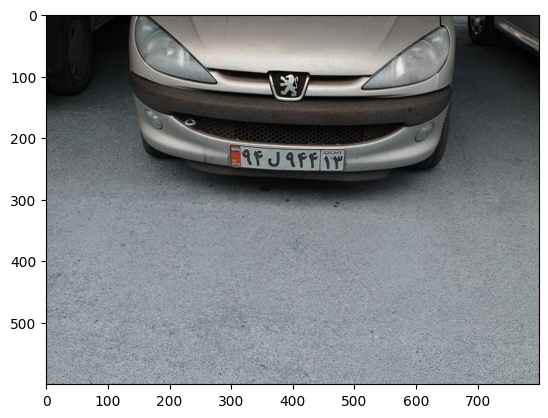

In [ ]:
# test it
h, w = img.shape[:2]
coordinates = [float(label[0]*w), float(label[1]*h),
               float(label[2]*w), float(label[3]*h),
               float(label[4]*w), float(label[5]*h),
               float(label[6]*w), float(label[7]*h)]

predicted_label, plate_image = read_single_modified(img, coordinates)
print('predicted : ', predicted_label)
plt.imshow(img)

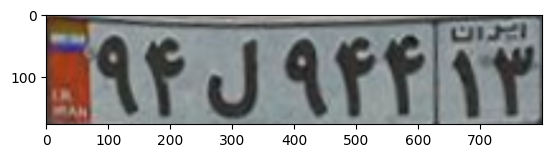

In [ ]:
plt.imshow(plate_image)

In [ ]:
def read_single(image: np.ndarray) -> str:
    plate_points = corner(image)
    plate_image = extract(image, plate_points)
    plate_image_resized = cv2.resize(plate_image, (800, 176))
    predicted_out = read_plate(plate_image_resized)

    return predicted_out

1/1 [==============================] - 0s 57ms/step
[[0.4102884  0.2956042  0.62344354 0.31067497 0.6063616  0.34669173
  0.41880417 0.34429955]]
1/1 [==============================] - 0s 99ms/step
predicted :  83V45884


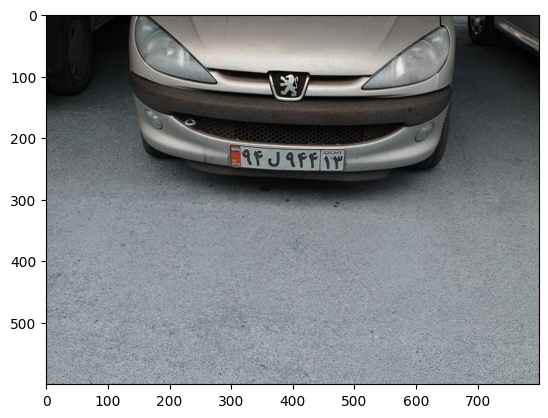

In [ ]:
# test it
predicted_label = read_single(img)
print('predicted : ', predicted_label)
plt.imshow(img)

**5. Optional: Images with Multiple Cars!**

**5.1. Clone and prepare a pretrained model**

YOLO (You Only Look Once)

In [ ]:
! pip install --upgrade tensorflow_hub

In [ ]:
%cd /content/drive/MyDrive/CV_4022

/content/drive/MyDrive/CV_4022


In [ ]:
! git clone https://github.com/pythonlessons/TensorFlow-2.x-YOLOv3.git

Cloning into 'TensorFlow-2.x-YOLOv3'...
remote: Enumerating objects: 809, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 809 (delta 5), reused 10 (delta 1), pack-reused 791
Receiving objects: 100% (809/809), 70.80 MiB | 14.94 MiB/s, done.
Resolving deltas: 100% (472/472), done.
Updating files: 100% (57/57), done.


In [ ]:
%cd /content/drive/MyDrive/CV_4022/TensorFlow-2.x-YOLOv3

/content/drive/MyDrive/CV_4022/TensorFlow-2.x-YOLOv3


In [ ]:
!pip install -r ./requirements.txt

In [ ]:
# yolov3
!wget -P model_data https://pjreddie.com/media/files/yolov3.weights

--2024-07-16 08:12:39--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘model_data/yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  31.9MB/s    in 7.8s    

2024-07-16 08:12:48 (30.4 MB/s) - ‘model_data/yolov3.weights’ saved [248007048/248007048]



<ipython-input-223-419ed3e73042>:17: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  load_yolo_weights(yolo, Darknet_weights) # use Darknet weights


1/1 [==============================] - 5s 5s/step


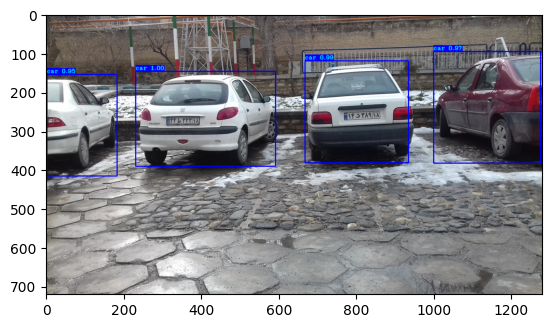

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from yolov3.yolov4 import *
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *

if YOLO_TYPE == "yolov4":
    Darknet_weights = YOLO_V4_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V4_WEIGHTS
if YOLO_TYPE == "yolov3":
    Darknet_weights = YOLO_V3_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V3_WEIGHTS

yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE)
load_yolo_weights(yolo, Darknet_weights) # use Darknet weights

multiple_dir = "/content/drive/MyDrive/CV_4022/multiple-cars/"
names = os.listdir(multiple_dir)
random_ind = random.randint(0, len(names))
image_path3   = multiple_dir + names[random_ind]
original = cv2.imread(image_path3)

image3, bboxes = detect_image(yolo, image_path3, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

CLASSES = YOLO_COCO_CLASSES
NUM_CLASS = read_class_names(CLASSES)
all_points = []
car_images = []
for i, bbox in enumerate(bboxes):
        class_ind = int(bbox[5])
        class_name = NUM_CLASS[class_ind]
        coor = np.array(bbox[:4], dtype=np.int32)
        xmin, ymin, xmax, ymax = coor
        if class_name == 'car':
          if ((xmax - xmin) > 0.25 * original.shape[1]) or (int(xmin) > 0 and int(ymin) > 0 and int(xmax) < original.shape[1] and int(ymax) < original.shape[0] and (xmax - xmin) > 0.1 * original.shape[1]):
            car_image = original[ymin:ymax, xmin:xmax]
            car_images.append(car_image)

plt.imshow(image3)

4


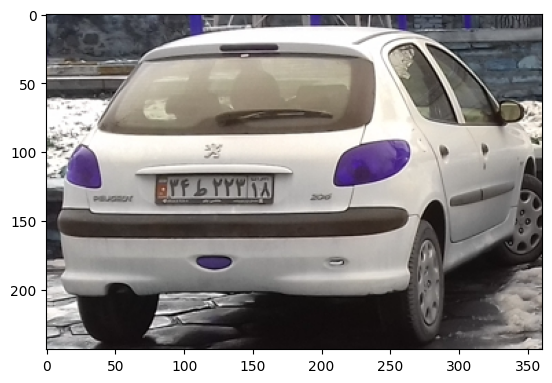

In [ ]:
print(len(car_images))
plt.imshow(car_images[0])

1/1 [==============================] - 0s 86ms/step
[[0.3225298  0.5449544  0.56494737 0.5440214  0.5567056  0.61671394
  0.33128396 0.60369295]]
1/1 [==============================] - 0s 216ms/step
predicted :  21SAD57310


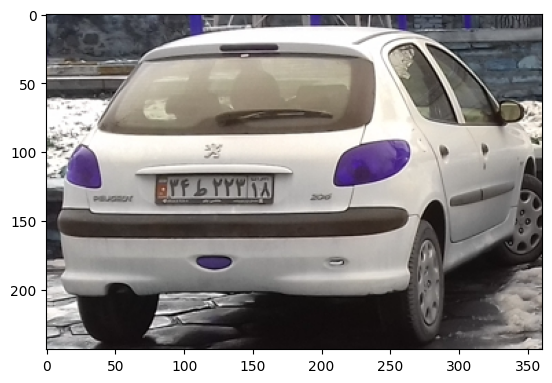

In [ ]:
# test it
predicted_label = read_single(car_images[0])
print('predicted : ', predicted_label)
plt.imshow(car_images[0])

**5.2. Integrate with previous part**

In [ ]:
# integrate.py

In [ ]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from yolov3.yolov4 import *
from yolov3.utils import load_yolo_weights, detect_image
from yolov3.configs import *

In [ ]:
def read_multiple(image_path: str) -> list[tuple[np.ndarray, str]]:
    original = cv2.imread(image_path)

    if YOLO_TYPE == "yolov4":
        Darknet_weights = YOLO_V4_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V4_WEIGHTS
    if YOLO_TYPE == "yolov3":
        Darknet_weights = YOLO_V3_TINY_WEIGHTS if TRAIN_YOLO_TINY else YOLO_V3_WEIGHTS

    yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE)
    load_yolo_weights(yolo, Darknet_weights) # use Darknet weights
    image, bboxes = detect_image(yolo, image_path3, '', input_size=YOLO_INPUT_SIZE, show=False, rectangle_colors=(255,0,0))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    CLASSES = YOLO_COCO_CLASSES
    NUM_CLASS = read_class_names(CLASSES)

    result = []
    for i, bbox in enumerate(bboxes):
      class_ind = int(bbox[5])
      class_name = NUM_CLASS[class_ind]
      coor = np.array(bbox[:4], dtype=np.int32)
      xmin, ymin, xmax, ymax = coor
      if class_name == 'car':
          if ((xmax - xmin) > 0.25 * original.shape[1]) or (int(xmin) > 0 and int(ymin) > 0 and int(xmax) < original.shape[1] and int(ymax) < original.shape[0] and (xmax - xmin) > 0.1 * original.shape[1]):
            car_image = original[ymin:ymax, xmin:xmax]
            plate_points = corner(car_image)
            plate_image = extract(car_image, plate_points)
            plate_image_resized = cv2.resize(plate_image, (800, 176))
            predicted_out = read_plate(plate_image_resized)
            result.append((plate_points, predicted_out))
    return result

In [ ]:
# test it
result = read_multiple(image_path3)

<ipython-input-226-dbed686af3d0>:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  load_yolo_weights(yolo, Darknet_weights) # use Darknet weights


1/1 [==============================] - 0s 90ms/step
[[0.3225298  0.5449544  0.56494737 0.5440214  0.5567056  0.61671394
  0.33128396 0.60369295]]
1/1 [==============================] - 0s 57ms/step
[[0.41157666 0.52422917 0.66349036 0.5275104  0.6530643  0.5909531
  0.4220584  0.59314746]]
1/1 [==============================] - 0s 59ms/step
[[0.38495564 0.4928844  0.58928394 0.50380147 0.57212454 0.5475317
  0.3963614  0.5423405 ]]
1/1 [==============================] - 0s 55ms/step
[[0.4178929  0.47720778 0.67795193 0.49013427 0.65078104 0.5511049
  0.42312023 0.54422444]]
1/1 [==============================] - 0s 106ms/step


In [ ]:
for res in result:
  print(res)

(array([116.4332552 , 132.96887827, 203.94599938, 132.74122834,
       200.97071946, 150.47820163, 119.59350839, 147.30107951]), '21SAD57310')
(array([109.89096782, 137.34804225, 177.15192479, 138.207726  ,
       174.36817092, 154.82971525, 112.68959373, 155.40463364]), '35ZA98190')
(array([106.24775791, 141.45782208, 162.64236832, 144.59102046,
       157.90637326, 157.14160478, 109.39574933, 155.65172839]), '68V83498')
(array([ 75.63861546, 124.55123055, 122.70929968, 127.92504421,
       117.79136741, 143.83837974,  76.58476171, 142.04257911]), '49T55340')


or

In [ ]:
# ! pip install ultralytics

In [ ]:
# from ultralytics import YOLO

# # Load a model
# model = YOLO("yolov8n.pt")  # pretrained YOLOv8n model

# dirs = []
# multiple_dir = "/content/drive/MyDrive/CV_4022/multiple-cars/"
# names = os.listdir(multiple_dir)
# for name in names:
#   dirs.append(multiple_dir + name)

# # Run batched inference on a list of images
# results = model(dirs)  # return a list of Results objects

# # Process results list
# for result in results:
#   boxes = result.boxes  # Boxes object for bounding box outputs
#   print('boxes ', boxes.xyxy)
#   # result.show()  # display to screen
#   # result.save(filename="result.jpg")  # save to disk